# Installing MASE (again)

Run the block below to install MASE in the current Colab runtime

In [1]:
# git_token = "YOUR_GIT_TOKEN"
# short_code = "YOUR_SHORT_CODE"

# # Check the current python version (It should be using Python 3.10) and update pip to the latest version.
# !python --version
# !python -m pip install --user --upgrade pip

# # Clone MASE from your branch (the branch must already exist)
# !git clone -b lab1_{short_code} https://{git_token}@github.com/DeepWok/mase.git

# # Install requirements
# !python -m pip install -r ./mase/machop/requirements.txt

# Change working directory to machop
%cd ../../../mase/machop
!./ch --help


[Errno 2] No such file or directory: '../../../mase/machop'
/home/wfp23/ADL/mase/docs/imgs/labs
/bin/bash: ./ch: No such file or directory


In [2]:
!ch --help

/bin/bash: ch: command not found


# General introduction

In this lab, you will learn how to use the search functionality in the software stack of MASE.

There are in total 4 tasks you would need to finish.

# Writing a search using MaseGraph Transforms

In this section, our objective is to gain a comprehensive understanding of the construction of the current search function in Mase. To achieve this, we will require these essential components:

- MaseGraph: This component should be already created in the preceding lab.
- Search space: This component encompasses and defines the various available search options.
- Search strategy: An implementation of a search algorithm.
- Runner: This vital component manages and executes training, evaluation, or both procedures while generating a quality metric.

By analyzing these components, we can delve into the workings and effectiveness of the existing search function in Mase.

#Turning your network to a graph

We follow a similar procedure of what you have tried in lab2 to now produce a MaseGraph, this is converted from your pre-trained JSC model:

In [3]:
import sys
import logging
import os
from pathlib import Path
from pprint import pprint as pp

# # figure out the correct path
# machop_path = Path(".").resolve().parent.parent /"machop"
# assert machop_path.exists(), "Failed to find machop at: {}".format(machop_path)
# sys.path.append(str(machop_path))

from chop.dataset import MaseDataModule, get_dataset_info
from chop.tools.logger import set_logging_verbosity

from chop.passes.graph.analysis import (
    report_node_meta_param_analysis_pass,
    profile_statistics_analysis_pass,
)
from chop.passes.graph import (
    add_common_metadata_analysis_pass,
    init_metadata_analysis_pass,
    add_software_metadata_analysis_pass,
)
from chop.tools.get_input import InputGenerator
from chop.ir.graph.mase_graph import MaseGraph

from chop.models import get_model_info, get_model




set_logging_verbosity("info")

batch_size = 256
model_name = "jsc-tiny"
dataset_name = "jsc"


data_module = MaseDataModule(
    name=dataset_name,
    batch_size=batch_size,
    model_name=model_name,
    num_workers=0,
    # custom_dataset_cache_path="../../chop/dataset"
)
data_module.prepare_data()
data_module.setup()

model_info = get_model_info(model_name)
model = get_model(
    model_name,
    task="cls",
    dataset_info=data_module.dataset_info,
    pretrained=False,
    checkpoint = None)

input_generator = InputGenerator(
    data_module=data_module,
    model_info=model_info,
    task="cls",
    which_dataloader="train",
)

dummy_in = next(iter(input_generator))
_ = model(**dummy_in)

# generate the mase graph and initialize node metadata
mg = MaseGraph(model=model)

/home/wfp23/anaconda3/envs/mase2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     Set logging level to info


#Defining a search space

Based on the previous `pass_args` template, the following code is utilized to generate a search space. The search space is constructed by combining different weight and data configurations in precision setups.

In [4]:
pass_args = {
"by": "type",
"default": {"config": {"name": None}},
"linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
},}

import copy
# build a search space
data_in_frac_widths = [(16, 8), (8, 6), (8, 4), (4, 2)]
w_in_frac_widths = [(16, 8), (8, 6), (8, 4), (4, 2)]
search_spaces = []
for d_config in data_in_frac_widths:
    for w_config in w_in_frac_widths:
        pass_args['linear']['config']['data_in_width'] = d_config[0]
        pass_args['linear']['config']['data_in_frac_width'] = d_config[1]
        pass_args['linear']['config']['weight_width'] = w_config[0]
        pass_args['linear']['config']['weight_frac_width'] = w_config[1]
        # dict.copy() and dict(dict) only perform shallow copies
        # in fact, only primitive data types in python are doing implicit copy when a = b happens
        search_spaces.append(copy.deepcopy(pass_args))

## Defining a search strategy and a runner

The code provided below consists of two main `for` loops. The first `for` loop executes a straightforward brute-force search, enabling the iteration through the previously defined search space.

In contrast, the second `for` loop retrieves training samples from the train data loader. These samples are then utilized to generate accuracy and loss values, which serve as potential quality metrics for evaluating the system's performance.


/home/wfp23/anaconda3/envs/mase2/lib/python3.11/site-packages/chop/actions/simulate.py:3: UserWarning: Python runners and associated APIs are an experimental feature and subject to change.
  from cocotb.runner import get_runner, get_results
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/wfp23/ADL/mase/docs/imgs/labs/lightning_logs

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | GraphModule        | 117   
1 | loss_fn   | CrossEntropyLoss   | 0     
2 | acc_train | MulticlassAccuracy | 0     
3 | acc_val   | MulticlassAccuracy | 0     
4 | acc_test  | MulticlassAccuracy | 0     
5 | loss_val  | MeanMetric         | 0     
6 | loss_test | MeanMetric         | 0     
-------------------------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.00

/home/wfp23/anaconda3/envs/mase2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/wfp23/anaconda3/envs/mase2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 3084/3084 [00:34<00:00, 88.43it/s, v_num=0, train_acc_step=0.719, val_acc_epoch=0.717, val_loss_epoch=0.843] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 3084/3084 [00:34<00:00, 88.42it/s, v_num=0, train_acc_step=0.719, val_acc_epoch=0.717, val_loss_epoch=0.843]
[Errno 2] No such file or directory: 'nvidia-smi'
No GPU found. Monitoring CPU usuage only.
Average Accuracy per Batch: 0.5885
Average Loss per Batch: 1.063
Average Latency per Batch: 865.76 nanoseconds
Average CPU Power Usage per Batch: 8.644W


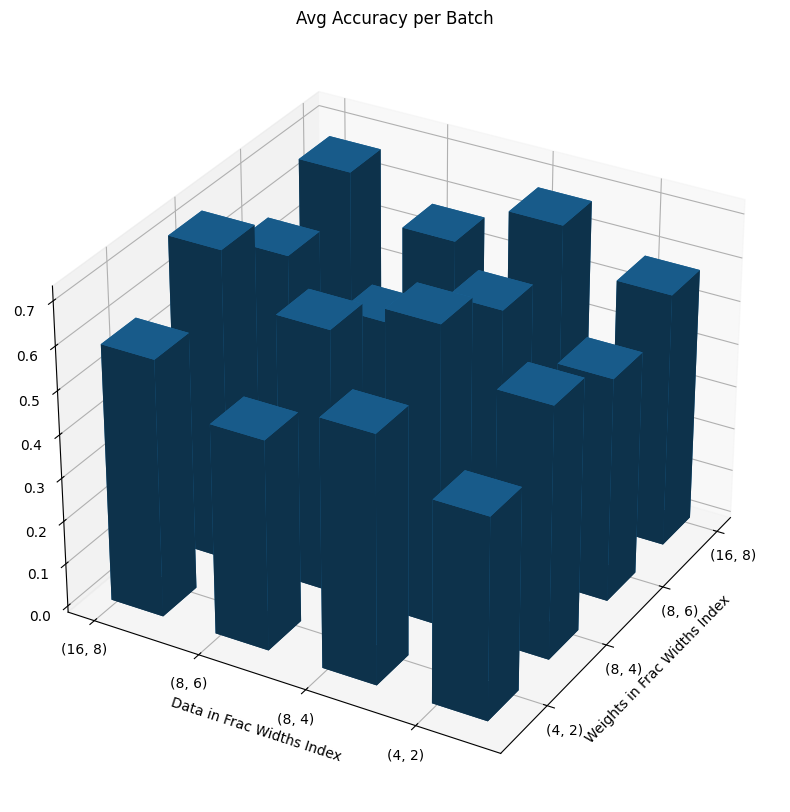

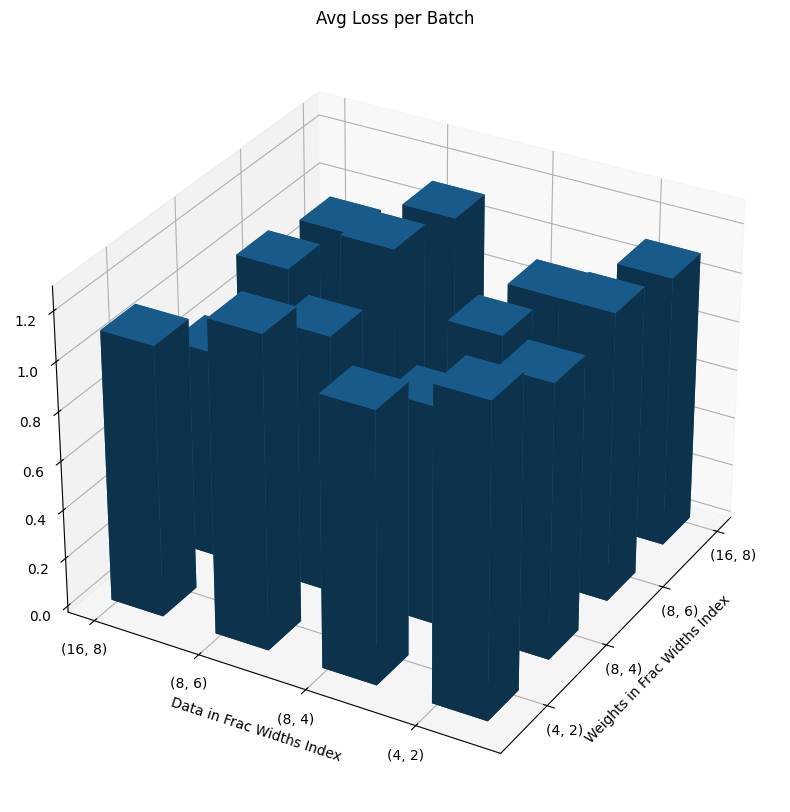

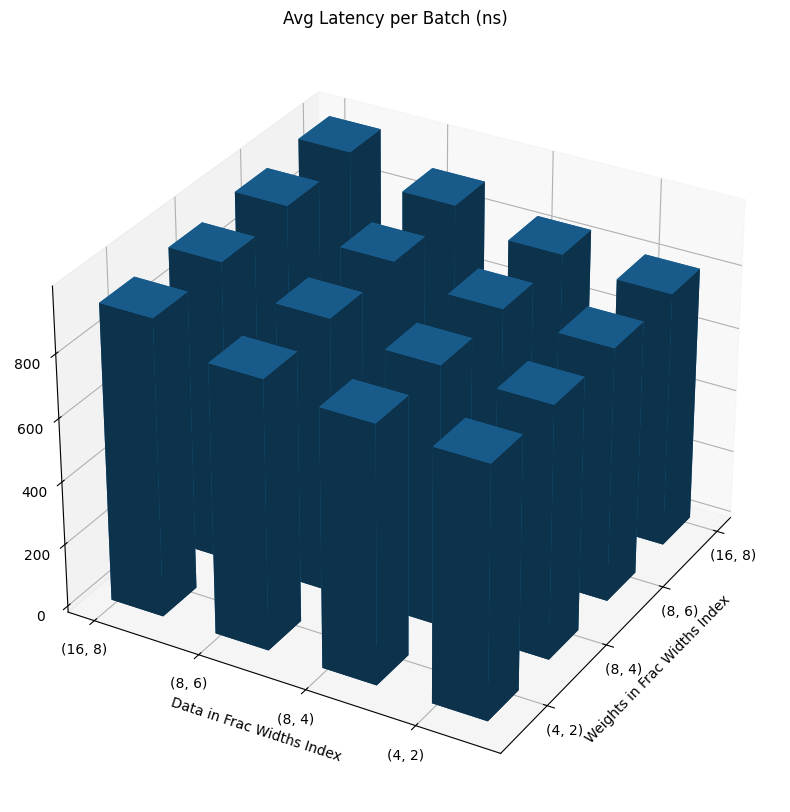

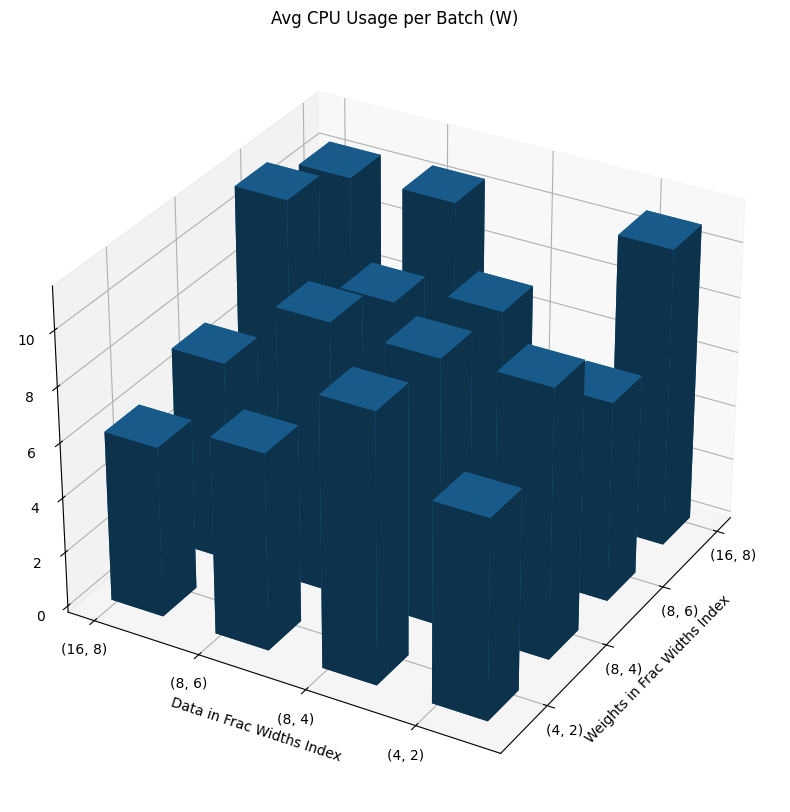

In [6]:
pass_args = {
"by": "type",
"default": {"config": {"name": None}},
"linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
},}

import copy
# build a search space
data_in_frac_widths = [(16, 8), (8, 6), (8, 4), (4, 2)]
w_in_frac_widths = [(16, 8), (8, 6), (8, 4), (4, 2)]
search_spaces = []
for d_config in data_in_frac_widths:
    for w_config in w_in_frac_widths:
        pass_args['linear']['config']['data_in_width'] = d_config[0]
        pass_args['linear']['config']['data_in_frac_width'] = d_config[1]
        pass_args['linear']['config']['weight_width'] = w_config[0]
        pass_args['linear']['config']['weight_frac_width'] = w_config[1]
        # dict.copy() and dict(dict) only perform shallow copies
        # in fact, only primitive data types in python are doing implicit copy when a = b happens
        search_spaces.append(copy.deepcopy(pass_args))


# grid search
import torch
from torchmetrics.classification import MulticlassAccuracy
import time
import subprocess
import psutil
import numpy as np
import matplotlib.pyplot as plt

from chop.passes.graph.transforms import (
    quantize_transform_pass,
    summarize_quantization_analysis_pass,
)

mg, _ = init_metadata_analysis_pass(mg, None)
mg, _ = add_common_metadata_analysis_pass(mg, {"dummy_in": dummy_in})
mg, _ = add_software_metadata_analysis_pass(mg, None)

from chop.actions import train, test
task = "lab3"
dataset_name = "jsc"
num_workers = os.cpu_count()
optimizer = "adam"
max_epochs: int = 2
max_steps: int = -1
gradient_accumulation_steps: int = 1
learning_rate: float = 5e-3
weight_decay: float = 0.0
lr_scheduler_type: str = "linear"
num_warmup_steps: int = 0
save_path: str = "./ckpts/lab3"
auto_requeue = False
load_name: str = None
load_type: str = ""
evaluate_before_training: bool = False
visualizer = None
profile: bool = True
plt_trainer_args = {
"max_epochs": max_epochs,
"accelerator": "cpu",
}
train(mg.model, model_info, data_module, data_module.dataset_info, task, optimizer, learning_rate, weight_decay, plt_trainer_args, auto_requeue, save_path, visualizer, load_name, load_type)

metric = MulticlassAccuracy(num_classes=5)
num_batchs = 5

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

def plot_metric_search_spaces(metric, title, x_label, y_label, search_space_config_x, search_space_config_y):
    """
    This function visualizes the performance metrics of different quantization configurations as a 3D bar chart. 
    It is designed to plot metrics (like accuracy, latency, etc.) across a two-dimensional grid of quantization 
    configurations, making it easier to compare the impact of different settings on model performance. 
    The metrics are plotted against two axes representing distinct dimensions of the search space (e.g., 
    data precision and weight precision configurations).

    Inputs:
    - metric: A list or array of metric values corresponding to each quantization configuration. 
            The length should match the product of the dimensions of the search space (e.g., 16 for a 4x4 grid).
    - title: The title of the plot, typically describing the metric being visualized.
    - x_label: Label for the x-axis, describing the dimension of the quantization configurations it represents.
    - y_label: Label for the y-axis, similarly describing its corresponding quantization dimension.
    - search_space_config_x: A list of labels for the x-axis ticks, representing distinct values in the first dimension of the search space.
    - search_space_config_y: A list of labels for the y-axis ticks, representing distinct values in the second dimension of the search space.

    Outputs:
    - None. The function directly creates and displays a 3D bar chart using matplotlib. The chart illustrates 
    the given metric across different configurations defined by `search_space_config_x` and `search_space_config_y`.

    Note: This function assumes that `metric` can be reshaped into a square grid (e.g., 4x4 for 16 configurations), 
    and it uses 3D plotting capabilities of matplotlib for visualization. It is particularly useful for analyzing 
    the effects of two varying quantization parameters on model performance in a visually intuitive manner.
    """
    # Reshape the metric values to fit a 4x4 grid (since we have 16 configurations)
    grid_shape = (4, 4)  # 4 data configurations x 4 weight configurations
    metric = np.array(metric).reshape(grid_shape)

    # Create the plot
    fig = plt.figure(figsize=(12,10))
    plt.tight_layout()

    ax = fig.add_subplot(111, projection='3d')

    # Adjust grid for plotting based on the new expectation
    y, x = np.meshgrid(np.arange(grid_shape[1]), np.arange(grid_shape[0]))
    x = x.flatten()
    y = y.flatten()
    z = np.zeros(grid_shape).flatten()

    # Bar width and depth
    dx = dy = 0.5

    # Plotting the metric as a 3D bar chart
    ax.bar3d(x, y, z, dx, dy, metric.T.flatten(), shade=True)

    # Set plot labels and title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticks([0, 1, 2, 3])
    ax.set_xticklabels([str(pair) for pair in search_space_config_x])
    ax.set_yticklabels([str(pair) for pair in search_space_config_y])

    ax.view_init(elev=30, azim=30)

    # Show the plot
    plt.show()

def additional_metrics(mg, search_spaces, plot=True):
    """
    This function evaluates the performance of different quantization configurations on a neural network model 
    by measuring various metrics such as accuracy, loss, latency, and hardware (GPU/CPU) utilizations. 
    It iterates over a set of quantization configurations, applies each to the model, and performs inference 
    on batches of data to collect performance metrics. The function aims to provide insights into the impact 
    of quantization on model efficiency and hardware resource usage, facilitating the selection of optimal 
    quantization settings for deployment.

    Inputs:
    - mg: A model graph or model wrapper that supports quantization transformations and inference.
    - search_spaces: An iterable containing different quantization configurations to be evaluated.
    - plot (bool): Indicates whether to plot the collected metrics against the quantization configurations.

    Outputs:
    - None. The function prints average values for accuracy, loss, latency, and hardware utilizations directly. 
    If the 'plot' argument is True, it also generates plots for these metrics.
    """
    def get_gpu_power_usage():
        try:
            smi_output = subprocess.check_output(['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits']).decode().strip()
            power_usage = [float(x) for x in smi_output.split('\n')]  # power usage in watts
            return power_usage, True
        except Exception as e:
            print(f"{e}\nNo GPU found. Monitoring CPU usuage only.")
            return [], False

    def get_cpu_utilization(): 
        try:
            cpu_utilization = psutil.cpu_percent(interval=None)
            return cpu_utilization, True
        except Exception as e:
            print(f"{e}\nNo CPU found.")
            return [], False


    # Check for GPU / CPU
    _, gpu_found = get_gpu_power_usage()
    _, cpu_found = get_cpu_utilization()

    recorded_accs = []
    recorded_losses = []
    recorded_latencies = []
    recorded_gpu_utilizations = []
    recorded_cpu_utilizations = []
    latencies = []
    cpu_tdp = 25 # Assuming a Thermal Design Power for the CPU of 25 watts

    # Brute Force Search
    for i, config in enumerate(search_spaces):
        mg, _ = quantize_transform_pass(mg, config)
        j = 0
        acc_avg, loss_avg = 0, 0
        accs, losses, gpu_power_usages, cpu_power_usages  = [], [], [], []
        
        # Runner loop
        for inputs in data_module.train_dataloader():
            xs, ys = inputs

            # Reset CPU utilization measurement
            _, _ = get_cpu_utilization()  # Call once to reset the measurement

            # Measure GPU power usage before prediction and warm up the GPU
            if gpu_found:
                gpu_power_before = sum(get_gpu_power_usage()[0])
                steps = 10

                # Warmup GPU 
                for _ in range(steps):
                    mg.model(xs) # don't record time

                start_gpu = torch.cuda.Event(enable_timing=True)
                end_gpu = torch.cuda.Event(enable_timing=True)
                start.record()

            start_time = time.time()
            preds = mg.model(xs)  # Model prediction
            end_time = time.time()
            latency_gpu = 0
            # GPU latency is measured differently to CPU latency
            if gpu_found:
                end.record()
                torch.cuda.synchronize()  # Wait for GPU operations to finish/syncronize
                latency_gpu = start_gpu.elapsed_time(end_gpu) # measured in milliseconds
                latencies.append(latency_gpu * 1.0e6)  # Convert to nanoseconds
            else:
                latencies.append((end_time - start_time) * 1.0e6)  # Convert to nanoseconds

            # Measure GPU power usage after prediction
            if gpu_found:
                gpu_power_after = sum(get_gpu_power_usage()[0])
                gpu_power_used = (gpu_power_after - gpu_power_before)  # Measured in W
                gpu_power_usages.append(gpu_power_used)

            # Measure CPU utilization and estimate power usage
            if cpu_found:
                cpu_utilization, _ = get_cpu_utilization()  # Get CPU utilization over operation duration
                estimated_cpu_power = (cpu_utilization / 100) * cpu_tdp  # Measured in W
                cpu_power_usages.append(estimated_cpu_power)

            acc = metric(preds, ys)
            accs.append(acc)
            loss = torch.nn.functional.cross_entropy(preds, ys)
            losses.append(loss)

            if j > num_batchs:
                break
            j += 1

        acc_avg = sum(accs) / len(accs)
        loss_avg = sum(losses) / len(losses)
        if cpu_found:
            avg_cpu_utilizations = sum(cpu_power_usages) / len(cpu_power_usages)
            recorded_cpu_utilizations.append(avg_cpu_utilizations)
        if gpu_found:
            avg_gpu_utilizations = sum(gpu_power_usages) / len(gpu_power_usages)
            recorded_gpu_utilizations.append(avg_gpu_utilizations)
        recorded_accs.append(acc_avg)
        recorded_losses.append(loss_avg)
        recorded_latencies.append(sum(latencies) / len(latencies))

    # Convert each tensor to a float
    recorded_accs = [tensor.item() for tensor in recorded_accs]
    recorded_losses = [tensor.item() for tensor in recorded_losses]
    avg_acc = np.mean(recorded_accs)
    print(f"Average Accuracy per Batch: {avg_acc:.4g}")

    loss_avg = np.mean(recorded_losses)
    print(f"Average Loss per Batch: {loss_avg:.4g}")

    avg_latency = np.mean(recorded_latencies)
    print(f"Average Latency per Batch: {avg_latency:.2f} nanoseconds")

    if gpu_found:
        avg_gpu_power_usage = np.mean(recorded_cpu_utilizations)
        print(f"Average GPU Power Usage per Batch: {avg_gpu_power_usage:.4g}W")
    if cpu_found:
        avg_cpu_utilization = np.mean(recorded_cpu_utilizations)
        print(f"Average CPU Power Usage per Batch: {avg_cpu_utilization:.4g}W")

    if plot:
        plot_metric_search_spaces(recorded_accs, 'Avg Accuracy per Batch', 'Weights in Frac Widths Index', 'Data in Frac Widths Index', w_in_frac_widths, data_in_frac_widths)
        plot_metric_search_spaces(recorded_losses, 'Avg Loss per Batch', 'Weights in Frac Widths Index', 'Data in Frac Widths Index', w_in_frac_widths, data_in_frac_widths)
        plot_metric_search_spaces(recorded_latencies, 'Avg Latency per Batch (ns)', 'Weights in Frac Widths Index', 'Data in Frac Widths Index', w_in_frac_widths, data_in_frac_widths)

        if gpu_found:
            plot_metric_search_spaces(recorded_gpu_utilizations, 'Avg GPU Usage per Batch (W)', 'Weights in Frac Widths Index', 'Data in Frac Widths Index', w_in_frac_widths, data_in_frac_widths)
        if cpu_found:
            plot_metric_search_spaces(recorded_cpu_utilizations, 'Avg CPU Usage per Batch (W)', 'Weights in Frac Widths Index', 'Data in Frac Widths Index', w_in_frac_widths, data_in_frac_widths)
    return

additional_metrics(mg, search_spaces, plot=True)

We now have the following task for you:

1. Explore additional metrics that can serve as quality metrics for the search process. For example, you can consider metrics such as latency, model size, or the number of FLOPs (floating-point operations) involved in the model.

2. Implement some of these additional metrics and attempt to combine them with the accuracy or loss quality metric. It's important to note that in this particular case, accuracy and loss actually serve as the same quality metric (do you know why?).



# The search command in the MASE flow

The search flow implemented in MASE is very similar to the one that you have constructed manually, the overall flow is implemented in [search.py](../../machop/chop/actions/search/search.py), the following bullet points provide you pointers to the code base.

- MaseGraph: this is the [MaseGraph](../../machop/chop/passes/graph/mase_graph.py) that you have used in lab2.
- Search space: The base class is implemented in [base.py](../../machop/chop/actions/search/search_space/base.py) , where in the same folder you can see a range of different supported search spaces.
- Search strategy: Similar to the search space, you can find a a base class [definition](../../machop/chop/actions/search/strategies/base.py), where different strategies are also defined in the same folder.
- Runner: Different [runners](../../machop/chop/actions/search/strategies/runners) can produce different metrics, they may also use `transforms` to help compute certain search metrics.

This enables one to execute the search through the MASE command line interface, remember to change the name after the `--load` option.


In [6]:
!./ch search --config configs/examples/jsc_toy_by_type.toml --load "/home/wfp23/ADL/mase/mase_output/Lab_1/JSC-Tiny/software/training_ckpts/best.ckpt" --load-type pl

/home/wfp23/ADL/mase/machop/chop/actions/simulate.py:3: UserWarning: Python runners and associated APIs are an experimental feature and subject to change.
  from cocotb.runner import get_runner, get_results
Seed set to 0
+-------------------------+--------------------------+----------------+--------------------------+--------------------------+
| Name                    |         Default          |  Config. File  |     Manual Override      |        Effective         |
+-------------------------+--------------------------+----------------+--------------------------+--------------------------+
| task                    |      classification      |      cls       |                          |           cls            |
| load_name               |           None           |                | /home/wfp23/ADL/mase/mas | /home/wfp23/ADL/mase/mas |
|                         |                          |                | e_output/Lab_1/JSC-Tiny/ | e_output/Lab_1/JSC-Tiny/ |
|                      

In [22]:
!./ch search --config configs/examples/jsc_toy_by_type_bf.toml --load "/home/wfp23/ADL/mase/mase_output/Lab_1/JSC-Tiny/software/training_ckpts/best.ckpt" --load-type pl

/home/wfp23/ADL/mase/machop/chop/actions/simulate.py:3: UserWarning: Python runners and associated APIs are an experimental feature and subject to change.
  from cocotb.runner import get_runner, get_results
Seed set to 0
+-------------------------+--------------------------+---------------+--------------------------+--------------------------+
| Name                    |         Default          | Config. File  |     Manual Override      |        Effective         |
+-------------------------+--------------------------+---------------+--------------------------+--------------------------+
| task                    |      classification      |      cls      |                          |           cls            |
| load_name               |           None           |               | /home/wfp23/ADL/mase/mas | /home/wfp23/ADL/mase/mas |
|                         |                          |               | e_output/Lab_1/JSC-Tiny/ | e_output/Lab_1/JSC-Tiny/ |
|                         |  

In this scenario, the search functionality is specified in the `toml` configuration file rather than via command-line inputs. This approach is adopted due to the multitude of configuration parameters that need to be set; encapsulating them within a single, elegant configuration file enhances reproducibility.

In `jsc_toy_by_type.toml`, the `search_space` configuration is set in `search.search_space`, the search strategy is configured via `search.strategy`. If you are not familiar with the `toml` syntax, you can read [here](https://toml.io/en/v1.0.0).

> In order to accomplish the following task, it is necessary to make direct modifications to the code base. This can be challenging within the Colab environment. **It is recommended to implement the task on a local setup and utilize Colab strictly as a server to execute the search command above.** Consider Colab as a dedicated server for this purpose.

With now an understanding of how the MASE flow work, consider the following tasks

3. Implement the brute-force search as an additional search method within the system, this would be a new search strategy in MASE.
4. Compare the brute-force search with the TPE based search, in terms of sample efficiency. Comment on the performance difference between the two search methods.